## Artificial Intelligence for Health analytics

Changhyun Kim (ID: 21134342)

### Preparing datasets

loading training, development, and test datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv("features/train.csv",sep=';')
train_data = train_data.drop(['name', 'frameTime'], axis=1)

devel_data = pd.read_csv("features/devel.csv",sep=';')
devel_data = devel_data.drop(['name', 'frameTime'], axis=1)

test_data = pd.read_csv("features/test.csv",sep=';')
test_data = test_data.drop(['name', 'frameTime'], axis=1)

In [3]:
freq_params = ['F0semitoneFrom27.5Hz_sma3nz_amean',
               'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
               'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
               'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
               'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
               'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
               'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
               'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
               'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
               'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
               'jitterLocal_sma3nz_amean',
               'jitterLocal_sma3nz_stddevNorm','F1frequency_sma3nz_amean',
               'F1frequency_sma3nz_stddevNorm', 'F1bandwidth_sma3nz_amean',
               'F1bandwidth_sma3nz_stddevNorm', 'F2frequency_sma3nz_amean',
               'F2frequency_sma3nz_stddevNorm', 'F2bandwidth_sma3nz_amean',
               'F2bandwidth_sma3nz_stddevNorm','F3frequency_sma3nz_amean',
               'F3frequency_sma3nz_stddevNorm', 'F3bandwidth_sma3nz_amean',
               'F3bandwidth_sma3nz_stddevNorm']

energy_params = ['loudness_sma3_amean',
       'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0',
       'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0',
       'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlope',
       'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope',
       'loudness_sma3_stddevFallingSlope','shimmerLocaldB_sma3nz_amean',
       'shimmerLocaldB_sma3nz_stddevNorm', 'HNRdBACF_sma3nz_amean',
       'HNRdBACF_sma3nz_stddevNorm']

spectral_params = ['spectralFlux_sma3_amean',
       'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean',
       'mfcc1_sma3_stddevNorm', 'mfcc2_sma3_amean', 'mfcc2_sma3_stddevNorm',
       'mfcc3_sma3_amean', 'mfcc3_sma3_stddevNorm', 'mfcc4_sma3_amean',
       'mfcc4_sma3_stddevNorm','logRelF0-H1-H2_sma3nz_amean',
       'logRelF0-H1-H2_sma3nz_stddevNorm', 'logRelF0-H1-A3_sma3nz_amean',
       'logRelF0-H1-A3_sma3nz_stddevNorm','F1amplitudeLogRelF0_sma3nz_amean',
       'F1amplitudeLogRelF0_sma3nz_stddevNorm', 'F2amplitudeLogRelF0_sma3nz_amean',
       'F2amplitudeLogRelF0_sma3nz_stddevNorm', 'F3amplitudeLogRelF0_sma3nz_amean',
       'F3amplitudeLogRelF0_sma3nz_stddevNorm', 'alphaRatioV_sma3nz_amean',
       'alphaRatioV_sma3nz_stddevNorm', 'hammarbergIndexV_sma3nz_amean',
       'hammarbergIndexV_sma3nz_stddevNorm', 'slopeV0-500_sma3nz_amean',
       'slopeV0-500_sma3nz_stddevNorm', 'slopeV500-1500_sma3nz_amean',
       'slopeV500-1500_sma3nz_stddevNorm','spectralFluxV_sma3nz_amean',
       'spectralFluxV_sma3nz_stddevNorm', 'mfcc1V_sma3nz_amean',
       'mfcc1V_sma3nz_stddevNorm', 'mfcc2V_sma3nz_amean',
       'mfcc2V_sma3nz_stddevNorm', 'mfcc3V_sma3nz_amean',
       'mfcc3V_sma3nz_stddevNorm', 'mfcc4V_sma3nz_amean',
       'mfcc4V_sma3nz_stddevNorm', 'alphaRatioUV_sma3nz_amean',
       'hammarbergIndexUV_sma3nz_amean', 'slopeUV0-500_sma3nz_amean',
       'slopeUV500-1500_sma3nz_amean', 'spectralFluxUV_sma3nz_amean',]

temporal_params = ['VoicedSegmentsPerSec', 'loudnessPeaksPerSec',
       'MeanVoicedSegmentLengthSec', 'StddevVoicedSegmentLengthSec',
       'MeanUnvoicedSegmentLength', 'StddevUnvoicedSegmentLength',
       'equivalentSoundLevel_dBp']

len(energy_params)

14

In [4]:
X_train = np.asarray(train_data.values)
X_devel = np.asarray(devel_data.values)
X_test = np.asarray(test_data.values)

print(X_train.shape)
print(X_devel.shape)
print(X_test.shape)

(9505, 88)
(9596, 88)
(9551, 88)


In [5]:
train_label = pd.read_csv('labels/train.csv')
train_label = train_label.drop(['file_name'], axis=1)

devel_label = pd.read_csv('labels/devel.csv')
devel_label = devel_label.drop(['file_name'], axis=1)

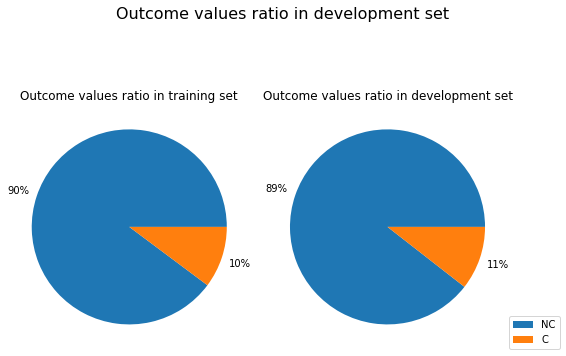

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(8,6), sharex=False, sharey=False)    
labels = ['NC', 'C']

for i, ax in enumerate(axes.flatten()):
    if i == 0:
        x = train_label.iloc[:,0]
        title = 'Outcome values ratio in training set'
    else:
        x = devel_label.iloc[:,0]
        title = 'Outcome values ratio in development set'
    
    ax.pie(x.value_counts(),  autopct='%1.0f%%', pctdistance=1.2)
    ax.set_title(title)

plt.legend(loc=(1,0), labels=labels)
plt.suptitle(title, size=16)
plt.tight_layout();
# plt.pie(train_label['Cold (upper respiratory tract infection)'].value_counts())
# plt.title('Distributions of SepsisLabel')
# plt.legend(loc=(1,0), labels=labels)
plt.show()

It's a bit causing confusion that 'NC' value denotes to value 1 which is usually used for indicating positive class. So, the values of the labels become 0 if the value is 'NC' and 1 if the value is 'C'.

In [7]:
train_label['Cold'] = train_label['Cold'].apply(lambda x: 1 if x == 'C' else 0)
devel_label['Cold'] = devel_label['Cold'].apply(lambda x: 1 if x == 'C' else 0)

In [8]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

encoder = LabelEncoder()
encoder.fit([0, 1])
y_train = encoder.transform(np.ravel(train_label))
y_devel = encoder.transform(np.ravel(devel_label))

print(encoder.classes_) # 'C' is encoded as 0 and 'NC' is encoded as 1
print(y_train.shape)
print(y_devel.shape)

[0 1]
(9505,)
(9596,)


### Define calculating performance functions

The pie charts above show the datasets are highly imbalanced which may be problematic if proper techniques are ignored and accuracy metrics is regarded as standard measurements.

To estimate the performance appropriately, the following metrics will be used:
- Accuracy
- Recall (Sensitivity)
- Precision
- ROC-AUC

In [9]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def calc_performance(y_true, y_pred):
    cm= confusion_matrix(y_true, y_pred)  

    #class_names contains the labels we would like to use. This can be ignored.
    class_names  =[0, 1]
    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)    
    disp.plot()
    
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Recall:', recall_score(y_true, y_pred))
    print('Precision:', precision_score(y_true, y_pred))    
    plt.show()
    
def plot_roc_curve(y_true, y_decision):
    fpr, tpr, _ = roc_curve(y_true, y_decision)
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc_score(y_true, y_decision),
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()
    

### Exploration of techniques to handle data imbalance

- Mixture of random upsampling and downsampling
- balancing class weights

In [10]:
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = RandomOverSampler(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy='majority')

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

minmax_scaler = MinMaxScaler()
X_train_scaled = minmax_scaler.fit_transform(X_train)
X_devel_scaled = minmax_scaler.transform(X_devel)

X_train_scaled_bal, y_train_bal = pipeline.fit_resample(X_train_scaled, y_train)

In [11]:
from sklearn.svm import SVC
from sklearn.utils import class_weight

class_weight_array = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
keys = [0, 1]
class_weight_dict = dict(zip(keys, class_weight_array))
random_seed = 20

In [12]:
underover_model = SVC(kernel='linear', C=0.1, probability=True, random_state = random_seed)
underover_model.fit(X_train_scaled_bal, y_train_bal)
y_pred_underover = underover_model.predict(X_devel_scaled)
y_pred_underover_prob = underover_model.predict_proba(X_devel_scaled)

class_bal_model = SVC(kernel='linear', C=0.1, probability=True, class_weight=class_weight_dict, random_state=random_seed)
class_bal_model.fit(X_train_scaled, y_train)
y_pred_weight = class_bal_model.predict(X_devel_scaled)
y_pred_weight_prob = class_bal_model.predict_proba(X_devel_scaled)

--------Random over-undersampling-----------
Accuracy: 0.6582951229679033
Recall: 0.5647873392680515
Precision: 0.16744868035190616


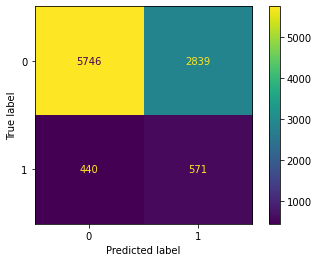

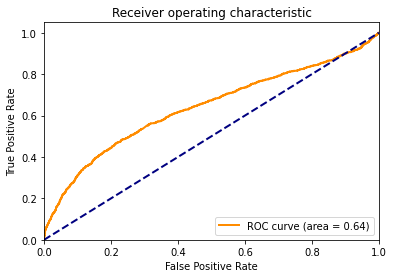

--------Balanced class weights--------------
Accuracy: 0.6641308878699458
Recall: 0.5519287833827893
Precision: 0.16766826923076922


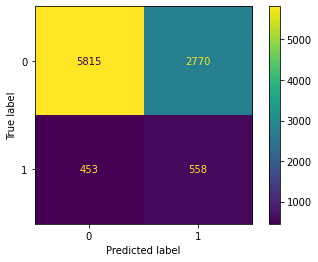

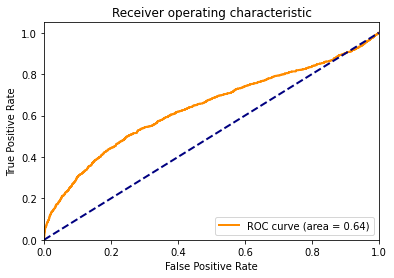

In [13]:
print('--------Random over-undersampling-----------')
calc_performance(y_devel, y_pred_underover)
plot_roc_curve(y_devel, y_pred_underover_prob[:,1])

print('--------Balanced class weights--------------')
calc_performance(y_devel, y_pred_weight)
plot_roc_curve(y_devel, y_pred_weight_prob[:,1])

There were no large difference or performance between both techniques. In this case, it can be concluded as cost-sensitive training is more efficient than the other due to it requires less memory. Balancing the number of outcome labels may not be helpful if it does not show remarkable improvement

In [229]:
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
grid = {'kernel': ['linear', 'rbf'], 'C': [0.01, 0.1, 1, 10]}

gridcv = GridSearchCV(SVC(class_weight=class_weight_dict, probability = True), param_grid=grid, cv=cv)

gridcv.fit(X_train_scaled, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20, shuffle=True),
             estimator=SVC(class_weight={0: 0.5568248388986526,
                                         1: 4.899484536082475},
                           probability=True),
             param_grid={'C': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf']})

Accuracy: 0.8605669028761984
Recall: 0.19090009891196835
Precision: 0.270687237026648


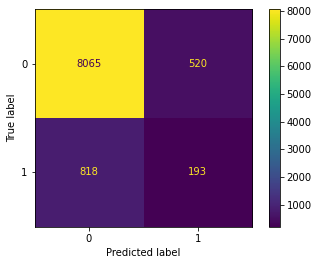

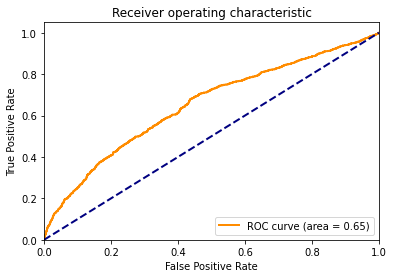

SVC(C=10, class_weight={0: 0.5568248388986526, 1: 4.899484536082475},
    probability=True)


In [230]:
y_pred = gridcv.predict(X_devel_scaled)
y_pred_prob = gridcv.predict_proba(X_devel_scaled)

calc_performance(y_devel, y_pred)
plot_roc_curve(y_devel, y_pred_prob[:,1])

baseline_model = gridcv.best_estimator_
print(baseline_model)

The optimal hyperparameter sets for the SVC model for baseline are:
- rbf kernel
- C == 10

### Task2 Neural Network Classification

Task2 is about exploring suitable 1D-Convolutional Neural Network(1D-CNN) and Feed-forward Neural Network(FNN). Prior to exploration, the identical procedure to find the better technique to handle imbalanced data as before. Baseline networks will be first defined. Then, each model will be run separately using narrow hyperparameter search space of grid search with the found imbalanced data solution.

Summaries of process:
- Finding the more appropriate method to handle imbalanced data through empirical training individual baseline networks
- Exploring the most optimal network topology, activation functions and regularisation functions using grid search
- Combine the FNN and 1D-CNN

Baselines
- 2 layers FNN such that 128 and 64 units for each layer
- Single Convolutional layer followed by Fully Connected layers. 


In [16]:
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras

from sklearn.preprocessing import StandardScaler

2022-05-30 18:37:36.572533: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-30 18:37:36.572557: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [17]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
    epoch = len(history.history['loss'])
    epoch_range = range(1, epoch+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [18]:
from sklearn.preprocessing import StandardScaler

n_features = X_train_scaled.shape[1]

over = RandomOverSampler(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy='majority')

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_devel_scaled = scaler.transform(X_devel)

X_train_scaled_bal, y_train_bal = pipeline.fit_resample(X_train_scaled, y_train)

y_train_vec = to_categorical(y_train, 2)
y_train_bal_vec = to_categorical(y_train_bal, 2)
y_devel_vec = to_categorical(y_devel, 2)

In [221]:
def create_baseline_FNN():
    model = Sequential()
    model.add(Dense(128, input_dim=n_features, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
    
#     print(model.summary())
    return model

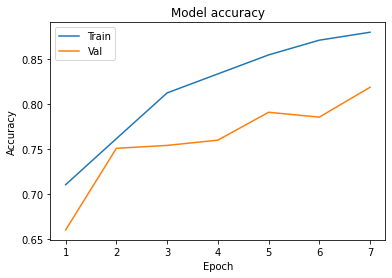

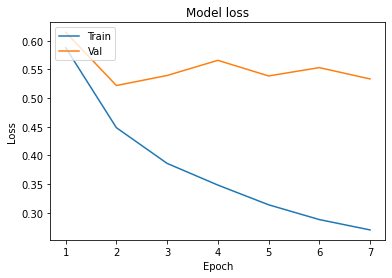

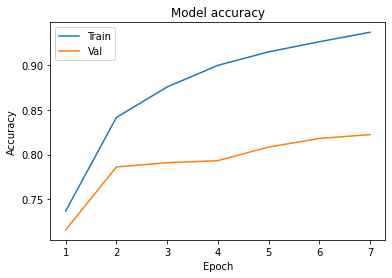

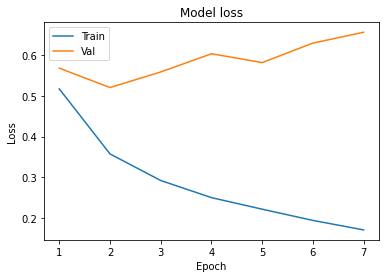

In [226]:
n_features = X_train_scaled.shape[1]

callback = EarlyStopping(monitor='val_loss', patience=5)
fnn_class = create_baseline_FNN()

epochs = 50
batch_size = 32

history = fnn_class.fit(X_train_scaled, y_train_vec,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_devel_scaled, y_devel_vec),
                 class_weight=class_weight_dict,
                 shuffle=True,
                callbacks=[callback],
                 verbose=0)

plot_learningCurve(history, epochs)

fnn_sampling = create_baseline_FNN()

history = fnn_sampling.fit(X_train_scaled_bal, y_train_bal_vec,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(X_devel_scaled, y_devel_vec),
                          shuffle=True,
                           callbacks=[callback],
                          verbose=0)

plot_learningCurve(history, epochs)

-----------FNN with class weight--------------
300/300 [==============================] - 0s 1ms/step
Accuracy: 0.8186744476865361
Recall: 0.33926805143422356
Precision: 0.24240282685512368


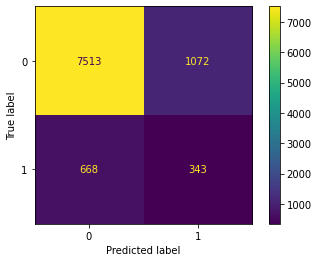

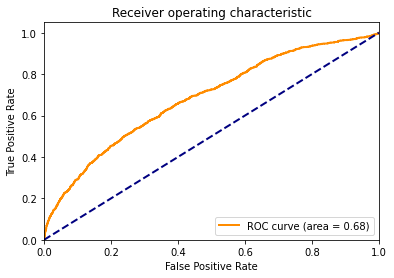

-----------FNN with under-oversampling--------------
300/300 [==============================] - 0s 1ms/step
Accuracy: 0.822426010837849
Recall: 0.3313550939663699
Precision: 0.2457813646368305


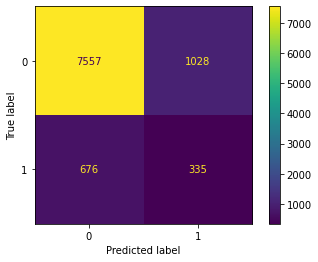

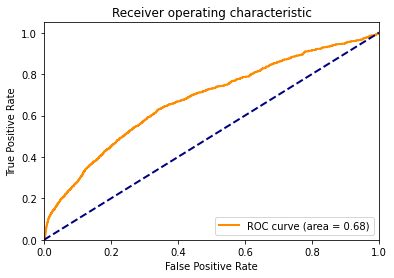

In [227]:
print('-----------FNN with class weight--------------')
y_pred_vec = fnn_class.predict(X_devel_scaled)

y_pred = np.argmax(y_pred_vec, axis=1)

calc_performance(y_devel, y_pred)
plot_roc_curve(y_devel, y_pred_vec[:,1])

print('-----------FNN with under-oversampling--------------')
y_pred_vec = fnn_sampling.predict(X_devel_scaled)

y_pred = np.argmax(y_pred_vec, axis=1)

calc_performance(y_devel, y_pred)
plot_roc_curve(y_devel, y_pred_vec[:,1])



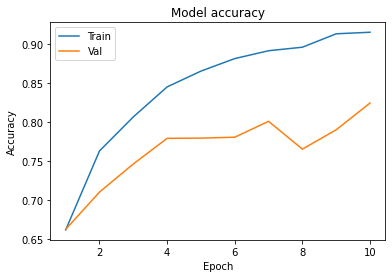

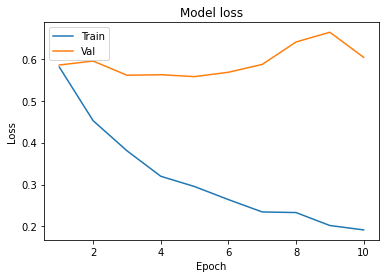

In [231]:
from keras.wrappers.scikit_learn import KerasClassifier

layer3_model = Sequential()
layer3_model.add(Dense(128, input_dim=n_features, activation='relu'))
layer3_model.add(Dropout(0.3))
layer3_model.add(Dense(64, activation='relu'))
layer3_model.add(Dropout(0.1))
layer3_model.add(Dense(32, activation='relu'))
layer3_model.add(Dense(2, activation='softmax'))
layer3_model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

history = layer3_model.fit(X_train_scaled, y_train_vec,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_devel_scaled, y_devel_vec),
                 class_weight=class_weight_dict,
                 shuffle=True,
                callbacks=[callback],
                 verbose=0)

plot_learningCurve(history, epochs)



-----------FNN with 3 layers-------------
300/300 [==============================] - 0s 1ms/step
Accuracy: 0.8247186327636515
Recall: 0.29080118694362017
Precision: 0.2335186656076251


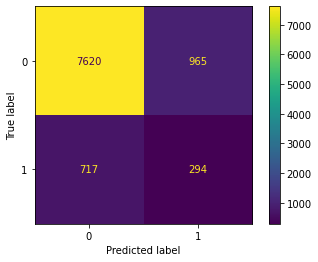

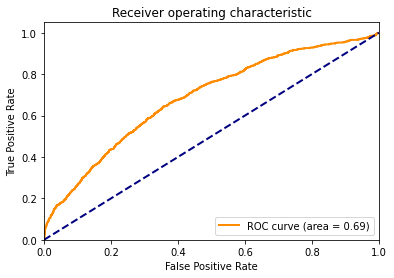

In [232]:
print('-----------FNN with 3 layers-------------')
y_pred_vec = layer3_model.predict(X_devel_scaled)

y_pred = np.argmax(y_pred_vec, axis=1)

calc_performance(y_devel, y_pred)
plot_roc_curve(y_devel, y_pred_vec[:,1])

In [22]:
from keras.layers import Conv2D, Conv1D, Reshape, AveragePooling1D
from keras.layers import MaxPooling2D, MaxPooling1D, BatchNormalization, InputLayer, Flatten
from keras.layers import preprocessing, Normalization
from keras.callbacks import EarlyStopping

In [23]:
normalizer = Normalization()
normalizer.adapt(X_train)

In [203]:
def create_cnn():
    model = Sequential()
    model.add(InputLayer(input_shape=(1, n_features)))
    model.add(normalizer)
    model.add(Conv1D(filters=64, 
                     kernel_size=1, 
                     input_shape=(1, n_features),
                    activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
    
    print(model.summary())
    return model

Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  multiple                 177       
 n)                                                              
                                                                 
 conv1d_99 (Conv1D)          (None, 1, 64)             5696      
                                                                 
 batch_normalization_166 (Ba  (None, 1, 64)            256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 1, 64)            0         
 g1D)                                                            
                                                                 
 flatten_77 (Flatten)        (None, 64)                0         
                                                     

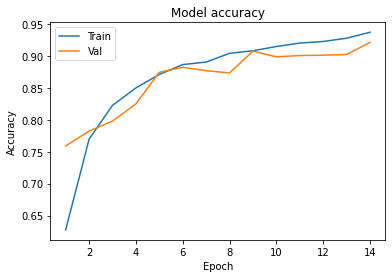

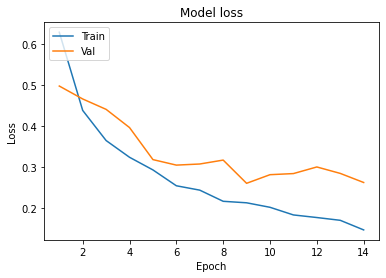

Model: "sequential_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  multiple                 177       
 n)                                                              
                                                                 
 conv1d_100 (Conv1D)         (None, 1, 64)             5696      
                                                                 
 batch_normalization_167 (Ba  (None, 1, 64)            256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 1, 64)            0         
 g1D)                                                            
                                                                 
 flatten_78 (Flatten)        (None, 64)                0         
                                                     

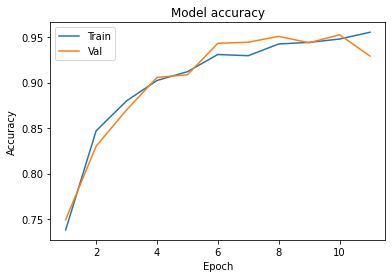

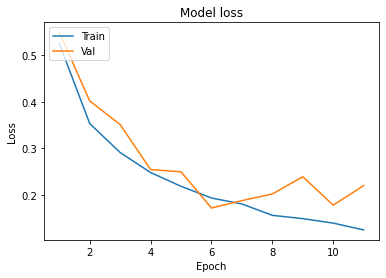

In [204]:
cnn_class = create_cnn()
epochs = 50
batch_size = 32

callback = EarlyStopping(monitor='val_loss', patience=5)
history = cnn_class.fit(
    X_train.reshape(X_train.shape[0], 1, n_features), 
    y_train_vec, 
    batch_size=batch_size, 
    epochs=epochs,
    validation_split = 0.2,
    shuffle=True,
    class_weight=class_weight_dict,
    callbacks=[callback],
    verbose=0
)
plot_learningCurve(history, epochs)

# Under-oversampling
X_train_bal, y_train_bal = pipeline.fit_resample(X_train, y_train)
y_train_bal_vec = to_categorical(y_train_bal, 2)

cnn_sampling = create_cnn()
history = cnn_sampling.fit(
#     X_train_bal.reshape(X_train_bal.shape[0], 1, n_features), 
    X_train_bal.reshape(X_train_bal.shape[0], 1, n_features),
    y_train_bal_vec, 
    batch_size=batch_size, 
    epochs=epochs,
    validation_split = 0.2,
    shuffle=True,
    callbacks=[callback],
    verbose=0
)
plot_learningCurve(history, epochs)


-----------CNN with class weights--------------
300/300 [==============================] - 1s 2ms/step
Accuracy: 0.8363901625677366
Recall: 0.2858555885262117
Precision: 0.2541776605101143


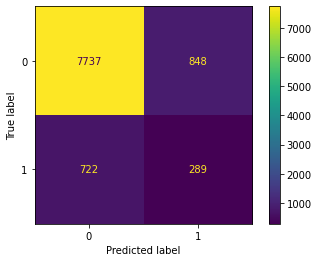

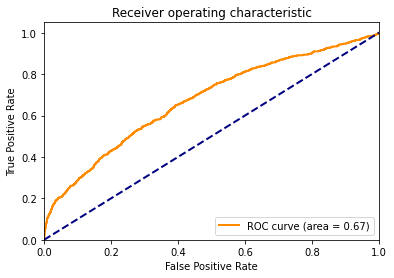

-----------CNN with under-oversampling--------------
300/300 [==============================] - 1s 1ms/step
Accuracy: 0.8403501458941226
Recall: 0.2433234421364985
Precision: 0.2428430404738401


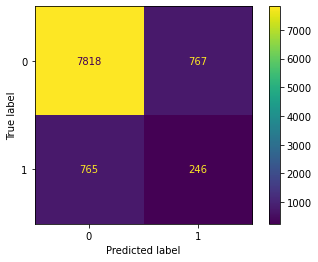

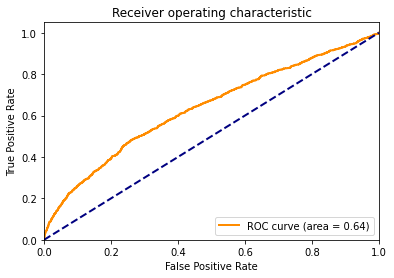

In [205]:
print('-----------CNN with class weights--------------')
y_pred_vec = cnn_class.predict(X_devel.reshape(X_devel.shape[0], 1, n_features))

y_pred = np.argmax(y_pred_vec, axis=1)

calc_performance(y_devel, y_pred)
plot_roc_curve(y_devel, y_pred_vec[:,1])

print('-----------CNN with under-oversampling--------------')
y_pred_vec = cnn_sampling.predict(X_devel.reshape(X_devel.shape[0], 1, n_features))
height
y_pred = np.argmax(y_pred_vec, axis=1)

calc_performance(y_devel, y_pred)
plot_roc_curve(y_devel, y_pred_vec[:,1])

### Combining CNN and FNN to be possible to utilise CNN on tabular data

Strategy

In [212]:
def create_combine(channels, dropout, activation):
    model = Sequential()
    model.add(InputLayer(input_shape=(1, n_features)))
    model.add(normalizer)
    model.add(Conv1D(filters=channels, 
                     kernel_size=1, 
                     activation=activation))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(32, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(16, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='rmsprop', loss = 'categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())
    return model

Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  multiple                 177       
 n)                                                              
                                                                 
 conv1d_105 (Conv1D)         (None, 1, 32)             2848      
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 1, 32)            0         
 g1D)                                                            
                                                                 
 dropout_220 (Dropout)       (None, 1, 32)             0         
                                                                 
 flatten_80 (Flatten)        (None, 32)                0         
                                                                 
 dense_232 (Dense)           (None, 32)             

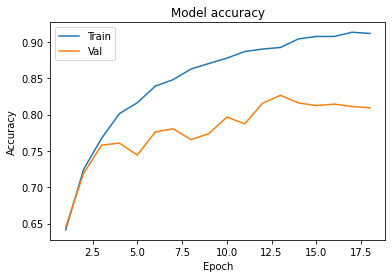

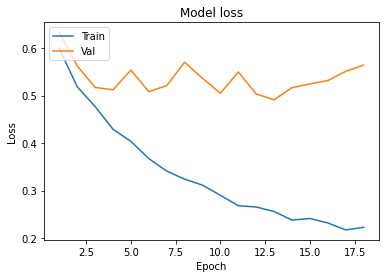

In [214]:
model = create_combine(32, 0.1, 'tanh')

epochs = 20
batch_size = 32

callback = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(
    X_train.reshape((X_train.shape[0], 1, n_features)), y_train_vec, 
    batch_size=batch_size, 
    epochs=epochs,
    validation_data=(X_devel.reshape((X_devel.shape[0], 1, n_features)), y_devel_vec),
    shuffle=True,
    class_weight=class_weight_dict,   
    callbacks=[callback],
    verbose=0
)
plot_learningCurve(history, epochs)

300/300 [==============================] - 1s 1ms/step
Accuracy: 0.8092955398082534
Recall: 0.35014836795252224
Precision: 0.2318271119842829


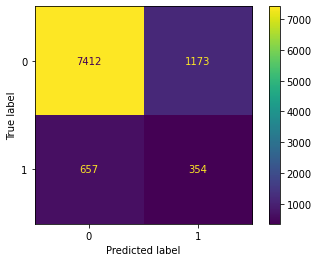

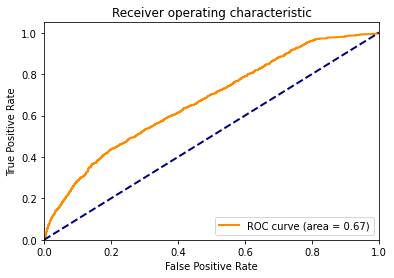

In [217]:
y_pred_vec = model.predict(X_devel.reshape((X_devel.shape[0], 1, n_features)))

y_pred = np.argmax(y_pred_vec, axis=1)

calc_performance(y_devel, y_pred)
plot_roc_curve(y_devel, y_pred_vec[:,1])